In [1]:
#creating synthetic data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from lifelines import KaplanMeierFitter

In [3]:


np.random.seed(42)
n = 5000  # number of individuals

# --- 1. Covariate generation ----------------------------------------------
age_at_entry = np.random.randint(25, 60, n) 
income_level = np.random.normal(40000, 12000, n).clip(15000, 120000)
health_score = np.random.normal(70, 10, n).clip(40, 100)
pension_contrib_rate = np.random.uniform(0.03, 0.12, n)

#  2. Weibull AFT parameters ----------------------------------------
k = 1.8  # shape parameter >1 → hazard increases over time

# regression coefficients for log(scale λ_i)
beta_age = -0.015      # older = earlier claim
beta_income = 0.000015 # higher income = later claim
beta_health = 0.01     # better health = later claim
beta_contrib = -2.0    # higher contrib rate = earlier claim
mu = 2.4             # intercept (base scale level)

# 3. Individual scale parameter λ_i ----------------------------------------
# log-linear model for scale parameter
log_lambda_i = (
    mu
    + beta_age * age_at_entry
    + beta_income * income_level
    + beta_health * health_score
    + beta_contrib * pension_contrib_rate
)
lambda_i = np.exp(log_lambda_i)

# --- 4. True event times (Weibull distributed) -----------------------------
true_time = np.random.weibull(k, n) * lambda_i  # years until claim

# --- 5. INFORMATIVE Right censoring (make censoring depend on covariates) ---
# Instead of random censoring, make censoring strongly related to covariates

# REASONING: Create strong covariate-dependent censoring to demonstrate IPCW effectiveness.
# In real pension data, censoring is rarely random - certain types of people systematically
# leave the study early (job changes, relocations, plan switches). By making censoring
# highly predictable from age, income, health, and contribution patterns, we create a 
# scenario where naive methods (zero/discard) will be biased, but IPCW can correct for
# these systematic differences. This allows us to showcase when and why IPCW provides
# substantial improvements over simpler censoring approache
# Base censoring risk 
base_censoring_risk = 0.3

# Strong censoring effects - make censoring highly predictable from covariates
gamma_age = -0.05      # younger people more likely to be censored (leave jobs)
gamma_income = 0.00005 # higher income = less likely to be censored (stable jobs) 
gamma_health = 0.02    # healthier people more likely to be censored (change jobs)
gamma_contrib = -5.0   # higher contributors less likely to be censored (committed)

# Calculate individual censoring probability based on covariates
censoring_linear_pred = (
    base_censoring_risk
    + gamma_age * age_at_entry
    + gamma_income * income_level  
    + gamma_health * health_score
    + gamma_contrib * pension_contrib_rate
)

# Convert to probabilities (sigmoid transformation)
censoring_prob = 1 / (1 + np.exp(-censoring_linear_pred))

# Generate censoring times based on individual risk
min_censor_time = 2.0   # minimum 2 years before censoring
max_censor_time = 25.0  # maximum 25 years

# High censoring probability = early censoring time
# Low censoring probability = late censoring time  
censor_time = min_censor_time + (max_censor_time - min_censor_time) * (1 - censoring_prob)

# Add randomness to censoring times
censor_time += np.random.normal(0, 1.5, n)  #  create small amount of noise so model predicts are not perfect
censor_time = np.clip(censor_time, min_censor_time, max_censor_time)

# Observed time & event indicator
observed_time = np.minimum(true_time, censor_time)
event_observed = (true_time <= censor_time).astype(int)
# --- 6. Combine into a DataFrame ------------------------------------------
df = pd.DataFrame({
    "id": np.arange(1, n + 1),
    "age_at_entry": age_at_entry,
    "income_level": income_level.round(2),
    "health_score": health_score.round(1),
    "pension_contrib_rate": pension_contrib_rate.round(3),
    "true_event_time": true_time.round(3),
    "censor_time": censor_time.round(3),
    "time_to_event": observed_time.round(3),
    "event_observed": event_observed
})

print(df.head())



   id  age_at_entry  income_level  health_score  pension_contrib_rate  \
0   1            53      36794.48          78.4                 0.052   
1   2            39      45557.62          62.0                 0.072   
2   3            32      35686.13          52.1                 0.048   
3   4            45      70045.55          75.5                 0.080   
4   5            43      49361.51          86.3                 0.054   

   true_event_time  censor_time  time_to_event  event_observed  
0            8.653        8.615          8.615               0  
1           32.314        3.319          3.319               0  
2           19.388        6.974          6.974               0  
3           34.158        2.380          2.380               0  
4           15.370        3.315          3.315               0  


In [4]:
# --- 7. Save to CSV --------------------------------------------------------
df.to_csv("synthetic_survival_data.csv", index=False)

In [5]:
# Check the shape of the DataFrame
df.shape 

(5000, 9)

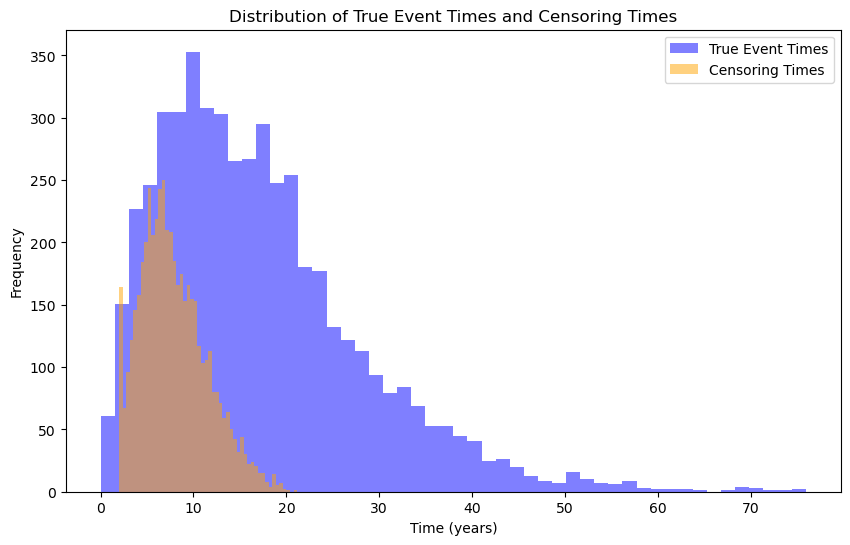

In [6]:
# --- 8. Visualize distributions of true event times and censoring times ----
df_copy = df.copy()
df_copy['True_Time'] = true_time.round(2)
df_copy['time_to_event'] = censor_time.round(2)

plt.figure(figsize=(10,6))
plt.hist(df_copy['True_Time'], bins=50, alpha=0.5, label='True Event Times', color='blue')
plt.hist(df_copy['time_to_event'], bins=50, alpha=0.5, label='Censoring Times', color='orange')
plt.xlabel('Time (years)')  
plt.ylabel('Frequency')
plt.title('Distribution of True Event Times and Censoring Times')
plt.legend()
plt.show()

Analyzing censoring pattern
Total observations: 5000
Events: 1241
Censored: 3759
Censoring rate: 0.752


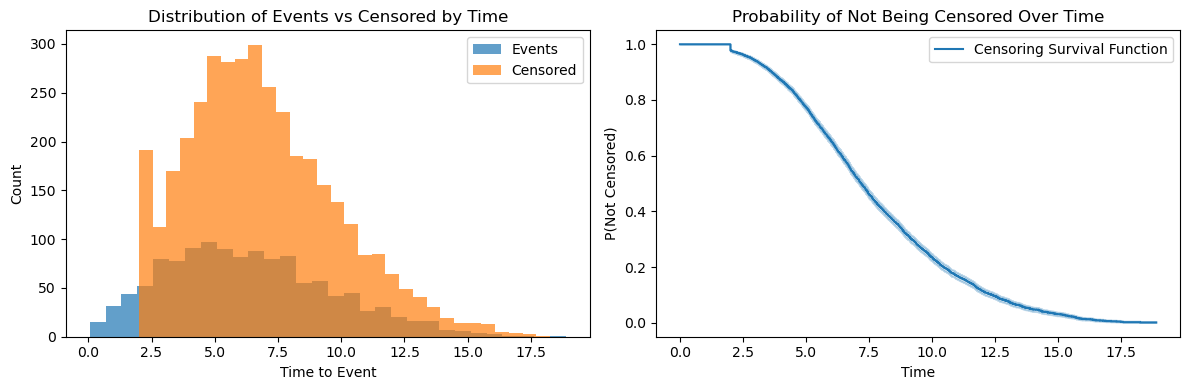


Censoring by covariates:
age_at_entry: Censored=40.619, Events=47.137, Diff=6.518
income_level: Censored=42282.637, Events=33562.084, Diff=8720.553
health_score: Censored=70.676, Events=67.498, Diff=3.178
pension_contrib_rate: Censored=0.074, Events=0.079, Diff=0.005


In [7]:
#--- 10. Analyze censoring pattern -----------------------------------------
print("Analyzing censoring pattern")

# Load and check the original data
print(f"Total observations: {len(df)}")
print(f"Events: {(df['event_observed'] == 1).sum()}")
print(f"Censored: {(df['event_observed'] == 0).sum()}")
print(f"Censoring rate: {(df['event_observed'] == 0).mean():.3f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df[df['event_observed'] == 1]['time_to_event'], 
         alpha=0.7, label='Events', bins=30)
plt.hist(df[df['event_observed'] == 0]['time_to_event'], 
         alpha=0.7, label='Censored', bins=30)
plt.xlabel('Time to Event')
plt.ylabel('Count')
plt.title('Distribution of Events vs Censored by Time')
plt.legend()

plt.subplot(1, 2, 2)
# Calculate survival function for censoring

km_c = KaplanMeierFitter()
km_c.fit(df["time_to_event"], 1 - df["event_observed"])  # 1=censored
km_c.plot(label='Censoring Survival Function')
plt.title('Probability of Not Being Censored Over Time')
plt.xlabel('Time')
plt.ylabel('P(Not Censored)')

plt.tight_layout()
plt.show()

# Check if censoring is informative - that they are related to the covariates used 
print("\nCensoring by covariates:")
for col in ['age_at_entry', 'income_level', 'health_score', 'pension_contrib_rate']:
    censored_mean = df[df['event_observed'] == 0][col].mean()
    event_mean = df[df['event_observed'] == 1][col].mean()
    print(f"{col}: Censored={censored_mean:.3f}, Events={event_mean:.3f}, Diff={abs(censored_mean-event_mean):.3f}")